


#  Analysis of questions asked on Stack Exchange

We will work on [The Data Science Stack Exchange website (DSSE)](https://datascience.stackexchange.com/), to determine which topics are most popular/asked about.

## Stack Exchange Data Explorer

After looking at some tables in the database, these look promising :
* Posts
* PostTags
* Tags

We can also use the table PostTypes to get the post type from the **PostTypeId** column in Posts.

These are the columns on which are main focus would be on in the Data:
* **Id** : An identification number for the post.
* **PostTypeId** : An identification number for the type of post.
* **CreationDate** : The date and time of creation of the post.
* **Score** : The post's score.
* **ViewCount** : How many times the post was viewed.
* **Tags** : What tags were used.
* **AnswerCount** : How many answers the question got (only applicable to question posts).
* **FavoriteCount** : How many times the question was favored (only applicable to question posts).

We're only going to focus on question posts of 2019 for this project.

## Getting the data

To get the data, we run the following query :

    select Id, PostTypeId, CreationDate,
           Score, ViewCount, Tags,
           AnswerCount, FavoriteCount
    from Posts
    where PostTypeId = 1 AND YEAR(CreationDate) = 2024;

## Exploring the data

In [ ]:
import pandas as pd

data = pd.read_csv("2024_questions.csv", parse_dates=["CreationDate"])

In [ ]:
data.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,128381,1,2024-03-21 00:43:07,0,14,<classification><machine-learning-model>,0,NaN
1,128380,1,2024-03-21 00:03:03,0,32,<machine-learning><predictive-modeling>,0,NaN
2,128378,1,2024-03-20 12:37:27,0,31,<deep-learning><transformer>,0,NaN
3,128377,1,2024-03-20 11:18:11,0,81,<machine-learning><nlp><gpt><chatbot><software...,0,NaN
4,128376,1,2024-03-20 10:49:02,0,16,<machine-learning><ai><graph-neural-network>,0,NaN


We can already see some missing values. Let's inspect them.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1618 non-null   int64         
 1   PostTypeId     1618 non-null   int64         
 2   CreationDate   1618 non-null   datetime64[ns]
 3   Score          1618 non-null   int64         
 4   ViewCount      1618 non-null   int64         
 5   Tags           1618 non-null   object        
 6   AnswerCount    1618 non-null   int64         
 7   FavoriteCount  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 101.2+ KB


We can see that **FavoriteCount** is the only column with missing values, counting 7432 null value. This means that these questions don't appear in anyone's favorites. We can change these values to 0.

## Data Cleaning

In [ ]:
data["FavoriteCount"].fillna(0, inplace=True)
data["FavoriteCount"] = data["FavoriteCount"].astype(int)

In [ ]:
data.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,128381,1,2024-03-21 00:43:07,0,14,<classification><machine-learning-model>,0,0
1,128380,1,2024-03-21 00:03:03,0,32,<machine-learning><predictive-modeling>,0,0
2,128378,1,2024-03-20 12:37:27,0,31,<deep-learning><transformer>,0,0
3,128377,1,2024-03-20 11:18:11,0,81,<machine-learning><nlp><gpt><chatbot><software...,0,0
4,128376,1,2024-03-20 10:49:02,0,16,<machine-learning><ai><graph-neural-network>,0,0


In [ ]:
data["Tags"] = data["Tags"].str.replace("^<|>$", "").str.split("><")

In [ ]:
data.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,128381,1,2024-03-21 00:43:07,0,14,"[<classification, machine-learning-model>]",0,0
1,128380,1,2024-03-21 00:03:03,0,32,"[<machine-learning, predictive-modeling>]",0,0
2,128378,1,2024-03-20 12:37:27,0,31,"[<deep-learning, transformer>]",0,0
3,128377,1,2024-03-20 11:18:11,0,81,"[<machine-learning, nlp, gpt, chatbot, softwar...",0,0
4,128376,1,2024-03-20 10:49:02,0,16,"[<machine-learning, ai, graph-neural-network>]",0,0


## Most used & most viewed Tags

We'll start by counting how many times each tag was used.

In [ ]:
tag_count = dict()

for tags in data["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

In [ ]:
tag_count = pd.DataFrame.from_dict(tag_count,orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
most_used = tag_count.sort_values("Count", ascending=True).tail(20)

In [ ]:
most_used

,Count
llm>,33
machine-learning-model,34
tensorflow,37
lstm,41
regression,42
data-science-model,43
classification,46
<time-series,50
time-series,50
pytorch,52


<Axes: >

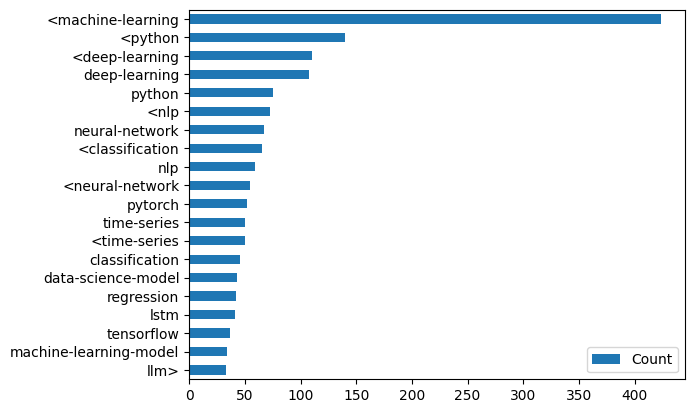

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
most_used.plot(kind="barh")

Now, we'll count views per tag.

In [ ]:
tag_views = {}

for i, tags in enumerate(data["Tags"]):
    for tag in tags:
        if tag in tag_views:
            tag_views[tag]+= data["ViewCount"].iloc[i]
        else:
            tag_views[tag]=1

In [ ]:
tag_view_count = pd.DataFrame.from_dict(tag_views, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

In [ ]:
most_viewed

,ViewCount
time-series,2495
nlp>,2569
gpt,2590
finetuning,2876
llm>,3084
pandas,3543
<neural-network,3604
<dataset,3818
pytorch>,3944
<nlp,5350


<Axes: >

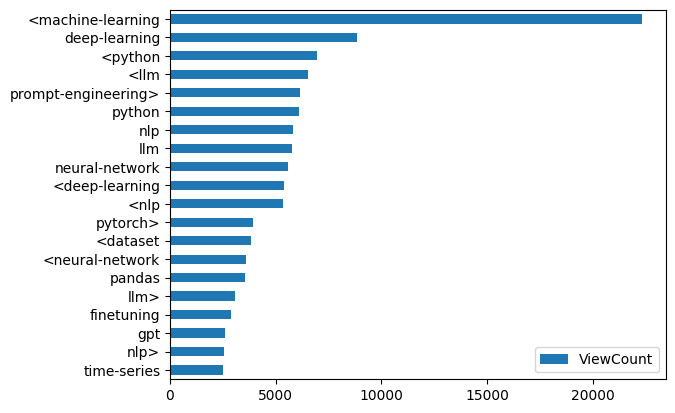

In [ ]:
most_viewed.plot(kind="barh")

We notice that most tags in **most_used** appear in **most_viewed**. Let's see what tags are not in **most_viewed**.

In [ ]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)

In [ ]:
in_used

,Count,ViewCount
llm>,33,3084.0
machine-learning-model,34,NaN
tensorflow,37,NaN
lstm,41,NaN
regression,42,NaN
data-science-model,43,NaN
classification,46,NaN
<time-series,50,NaN
time-series,50,2495.0
pytorch,52,NaN


And tags that are not in **most_used**.

In [ ]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

In [ ]:
in_viewed

,Count,ViewCount
time-series,50.0,2495
nlp>,NaN,2569
gpt,NaN,2590
finetuning,NaN,2876
llm>,33.0,3084
pandas,NaN,3543
<neural-network,55.0,3604
<dataset,NaN,3818
pytorch>,NaN,3944
<nlp,73.0,5350


## Relationships between tags

## Is deep learning just a fad ?

In this we will track the interest in deep learning across time. We will:

* Count how many deep learning questions are asked per time period.
* The total amount of questions per time period.
* How many deep learning questions there are relative to the total amount of questions per time period.

In [ ]:
all_q = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

In [ ]:
all_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [ ]:
all_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37071 entries, 0 to 37070
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             37071 non-null  int64         
 1   PostTypeId     37071 non-null  int64         
 2   CreationDate   37071 non-null  datetime64[ns]
 3   Score          37071 non-null  int64         
 4   ViewCount      37071 non-null  int64         
 5   Tags           37071 non-null  object        
 6   AnswerCount    37071 non-null  int64         
 7   FavoriteCount  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.3+ MB


### Transforming the tags column

In [ ]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")


In [ ]:
all_q.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,5,1,2014-05-13 23:58:30,9,978,[<machine-learning>],1,NaN
1,7,1,2014-05-14 00:11:06,4,516,"[<education, open-source>]",3,NaN
2,14,1,2014-05-14 01:25:59,26,1946,"[<data-mining, definitions>]",4,NaN
3,15,1,2014-05-14 01:41:23,2,659,[<databases>],0,NaN
4,16,1,2014-05-14 01:57:56,17,444,"[<machine-learning, bigdata, libsvm>]",2,NaN


In [ ]:
all_q["Tags"]

0            [python, keras, tensorflow, cnn, probability]
1                                         [neural-network]
2                            [python, ibm-watson, chatbot]
3                                                  [keras]
4        [r, predictive-modeling, machine-learning-mode...
5                                                    [cnn]
6                             [machine-learning, learning]
7                                       [machine-learning]
8                        [python, keras, tensorflow, lstm]
9                 [neural-network, feature-selection, mlp]
10               [predictive-modeling, recommender-system]
11                         [python, classification, keras]
12                                [python, neural-network]
13                                      [python, anaconda]
14          [python, neural-network, deep-learning, keras]
15                   [python, scikit-learn, random-forest]
16       [data-mining, time-series, lstm, rnn, data-cle.

In [ ]:
# identify deep learning questions

def is_dl(tags):
    for tag in tags:
        if tag in ["keras", "cnn", "tensorflow", "neural-network", "lstm", "deep-learning", "rnn", "scikit-learn"]:
            return 1
        else:
            return 0

In [ ]:
all_q["DL"] = all_q["Tags"].apply(is_dl)

In [ ]:
all_q.sample(5)

,Id,CreationDate,Tags,DL
8584,28269,2018-02-24 20:00:00,"[machine-learning, python, natural-language-pr...",0
12568,51860,2019-05-13 02:44:35,"[keras, cnn, lstm, image-classification, trans...",1
17684,32515,2018-06-01 19:52:45,"[time-series, methodology, methods]",0
10469,19620,2017-06-11 02:39:27,"[data-mining, dataset, preprocessing]",0
2603,56493,2019-07-27 17:25:56,"[machine-learning, classification, scikit-lear...",0


Let's track interest in deep learning before 2020.

In [ ]:
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

In [ ]:
# get the quarter
def get_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(get_quarter)

In [ ]:
all_q.sample(5)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,DL,Quarter
11198,40353,1,2018-10-28 18:47:12,1,57,"[<machine-learning, regression, objective-func...",0,NaN,0,18Q4
11833,42561,1,2018-12-13 16:07:54,5,220,"[<machine-learning, neural-network, deep-learn...",1,NaN,0,18Q4
6663,25969,1,2017-12-24 18:10:23,1,490,"[<time-series, matlab, model-selection>]",0,NaN,0,17Q4
14672,52110,1,2019-05-17 08:33:43,1,46,[<reinforcement-learning>],0,NaN,0,19Q2
8574,31578,1,2018-05-12 18:03:31,3,133,"[<machine-learning, python, supervised-learnin...",0,NaN,0,18Q2


In [42]:
q_per_quarter = all_q.groupby(["Quarter"]).agg({"DL":["sum", "size"]})

In [44]:
q_per_quarter.columns = ["DLquestions", "totalq"]

In [46]:
q_per_quarter["rate"] = q_per_quarter["DLquestions"] / q_per_quarter["totalq"]

In [47]:
q_per_quarter.reset_index(inplace=True)

In [48]:
q_per_quarter.sample(5)

,Quarter,DLquestions,totalq,rate
18,18Q4,0,1264,0.0
7,16Q1,0,510,0.0
16,18Q2,0,1412,0.0
9,16Q3,0,574,0.0
14,17Q4,0,887,0.0


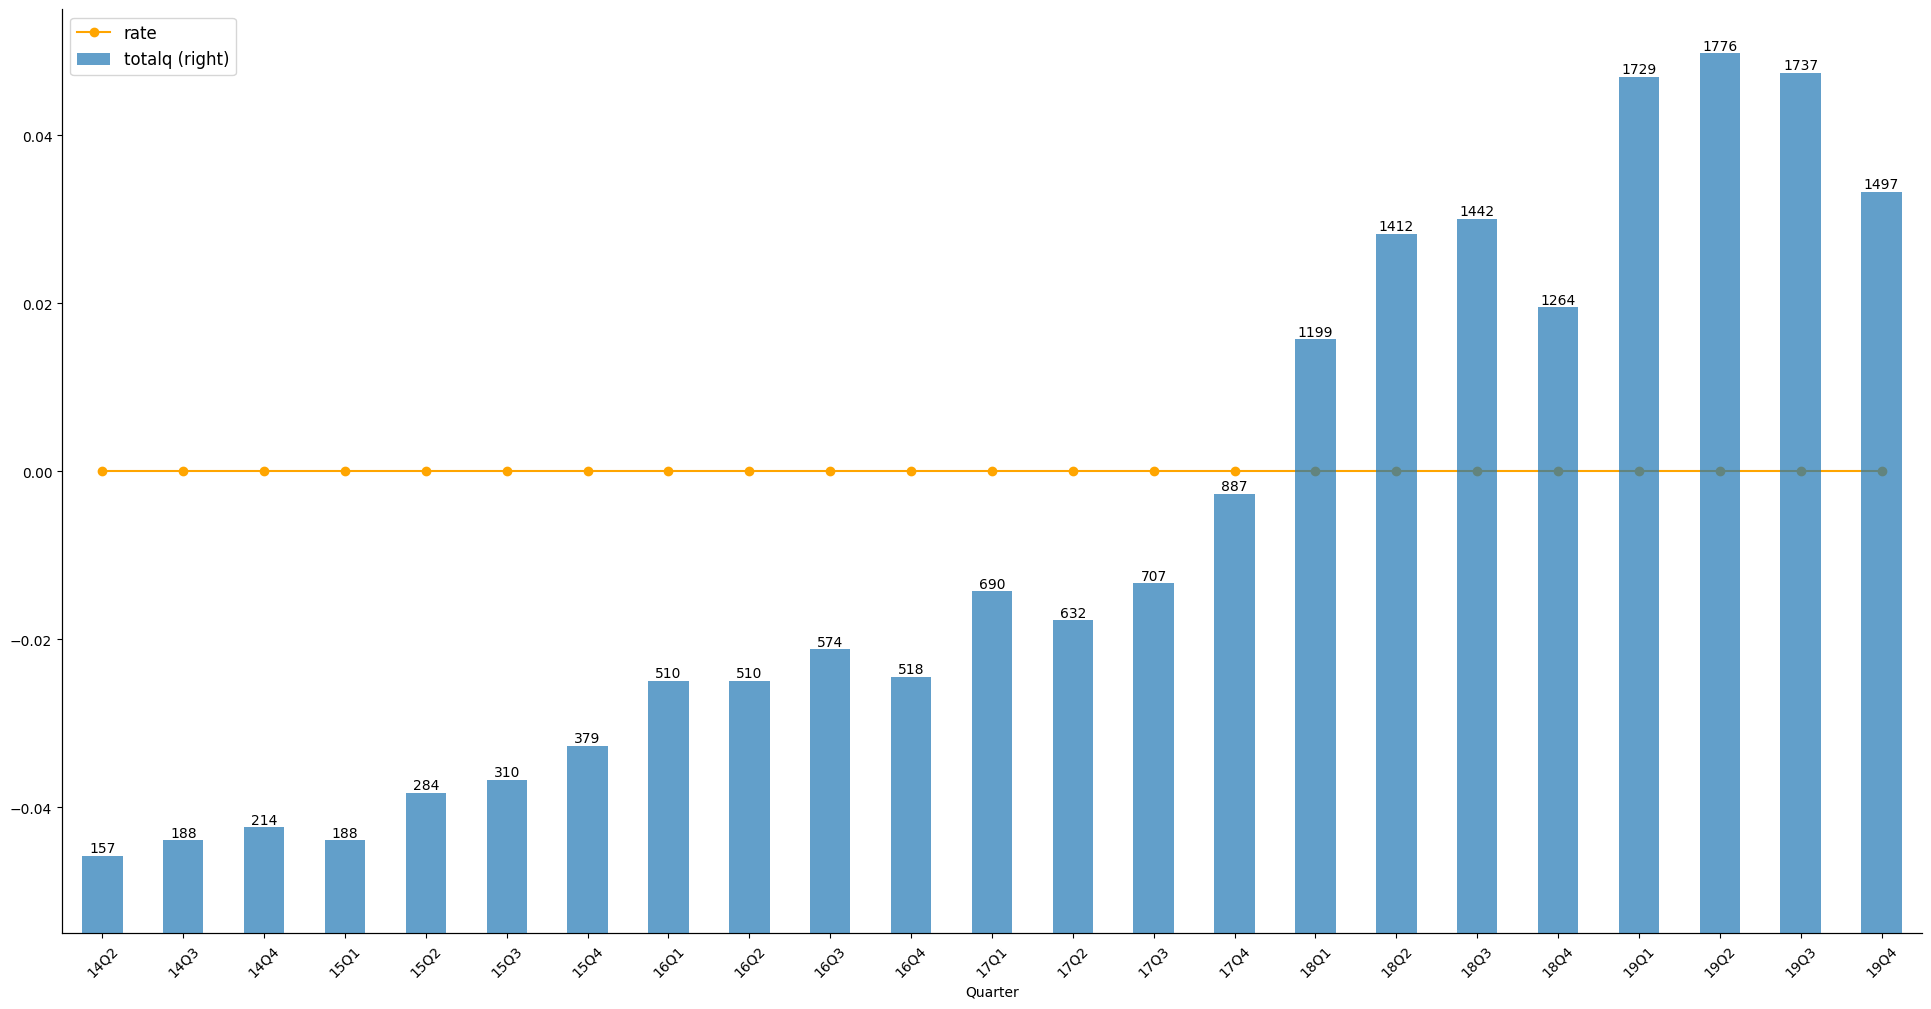

In [49]:
ax1 = q_per_quarter.plot(x="Quarter", y="rate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = q_per_quarter.plot(x="Quarter", y="totalq",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in enumerate(q_per_quarter["totalq"]):
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It looks like interest in deep learning has been increasing since the beginning of DSSE. However, it seems like the interest is plateauing. Since there is no sign of decreasing interest, we continue with the idea of making deep learing content